In [133]:
 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import gc

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['X_train.csv', 'sample_submission.csv', 'X_test.csv', 'y_train.csv']


In [134]:
train=pd.read_csv("../input/X_train.csv")
y=pd.read_csv("../input/y_train.csv")
test=pd.read_csv("../input/X_test.csv")

In [135]:
train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [136]:
y.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


Data exploation

In [137]:
train.shape,test.shape

((487680, 13), (488448, 13))

numericla features in train data

In [138]:
train.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


now our target variable  analysis 

In [139]:
y.head(),y.shape,y.columns

(   series_id  group_id        surface
 0          0        13  fine_concrete
 1          1        31       concrete
 2          2        20       concrete
 3          3        31       concrete
 4          4        22     soft_tiles,
 (3810, 3),
 Index(['series_id', 'group_id', 'surface'], dtype='object'))

In [140]:
target=y['surface'].value_counts().reset_index().rename(columns={"index":"target"})

In [141]:
target.head()

,target,surface
0,concrete,779
1,soft_pvc,732
2,wood,607
3,tiled,514
4,fine_concrete,363


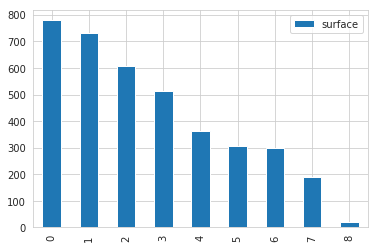

In [142]:
target.plot.bar()

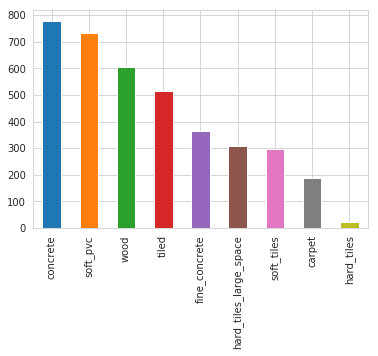

In [143]:
y['surface'].value_counts().plot.bar()


***DATA PreProcessing****

In [144]:
train.isnull().sum()

row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64

No missing values on the train data

In [145]:
train['is_duplicate'] = train.duplicated()
train['is_duplicate'].value_counts()

False    487680
Name: is_duplicate, dtype: int64

No duplicates on the train data

In [146]:
train = train.drop(['is_duplicate'], axis = 1)

In [147]:
train_sort_value=train.sort_values(by=['series_id','measurement_number'],ascending=True)

In [148]:
train_sort_value.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


Min and max values of each feature of the train data 

In [149]:
train.max(),train.min()

(row_id                    999.00000
 series_id                3809.00000
 measurement_number        127.00000
 orientation_X               0.98910
 orientation_Y               0.98898
 orientation_Z               0.15571
 orientation_W               0.15477
 angular_velocity_X          2.28220
 angular_velocity_Y          1.07910
 angular_velocity_Z          1.38730
 linear_acceleration_X      36.79700
 linear_acceleration_Y      73.00800
 linear_acceleration_Z      65.83900
 dtype: float64, row_id                     0.00000
 series_id                  0.00000
 measurement_number         0.00000
 orientation_X             -0.98910
 orientation_Y             -0.98965
 orientation_Z             -0.16283
 orientation_W             -0.15662
 angular_velocity_X        -2.37100
 angular_velocity_Y        -0.92786
 angular_velocity_Z        -1.26880
 linear_acceleration_X    -36.06700
 linear_acceleration_Y   -121.49000
 linear_acceleration_Z    -75.38600
 dtype: float64)

1. Correlations of features Train data

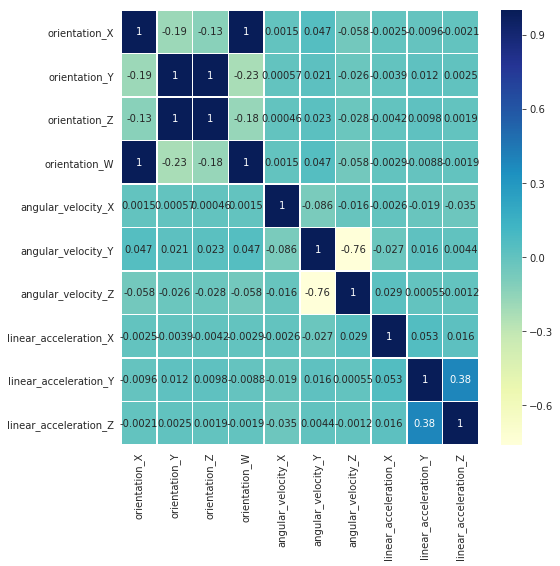

In [150]:
f,ax=plt.subplots(1,1 ,figsize=(8,8))
sns.heatmap(train.iloc[:,3:].corr(),annot=True,linewidths=.5,cmap="YlGnBu",ax=ax)

 Correlations of features Test data

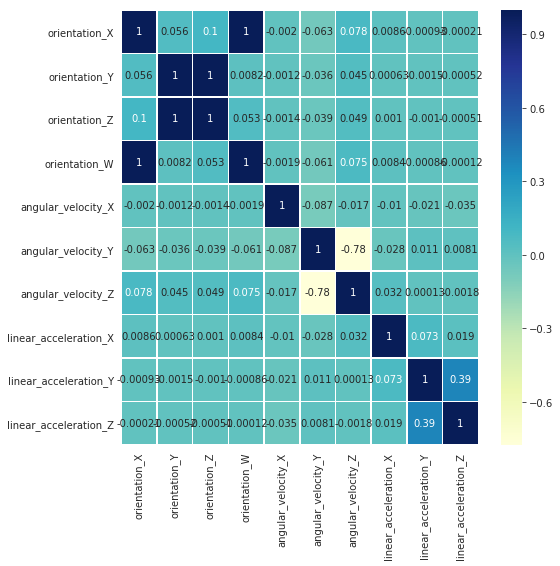

In [151]:
f,ax=plt.subplots(1,1 ,figsize=(8,8))
sns.heatmap(test.iloc[:,3:].corr(),annot=True,linewidths=.5,cmap="YlGnBu",ax=ax)


well , some fetures strongly  Correlated to each other
* Angular_velocity_Y is related to Angular_velocity_Z
* Linear_Acceleration_Y is related to the Linear_Acceleration_Z

In [152]:
def feature_distribution_plot(train, test, label1, label2, features,a=2,b=5):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(17,9))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        sns.kdeplot(train[feature], bw=0.5,label=label1)
        sns.kdeplot(test[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show(); 

<Figure size 432x288 with 0 Axes>

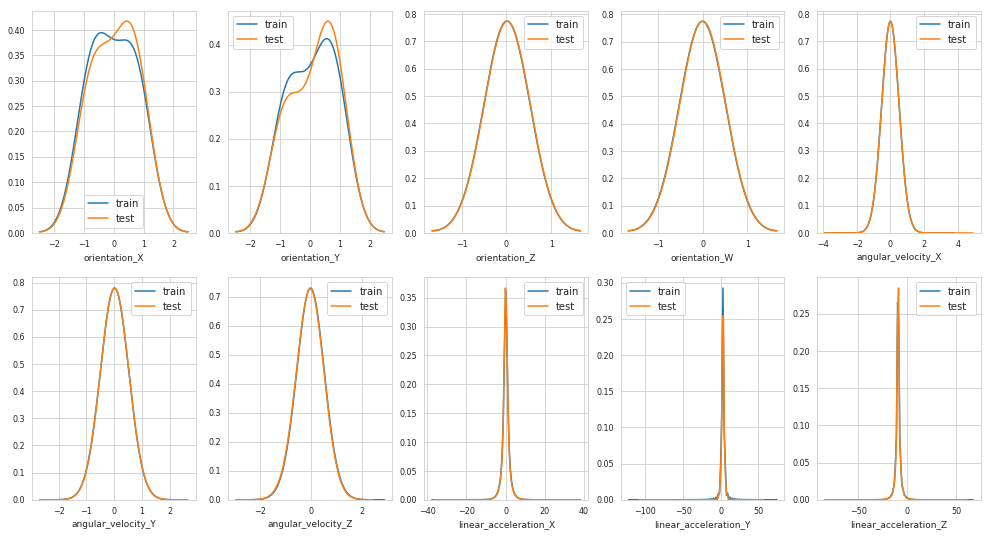

In [153]:
features = train.columns.values[3:]
feature_distribution_plot(train, test, 'train', 'test', features)

* Godd news, our basic features have the same distribution (Normal) on test and training. There are some differences between orientation_X , orientation_Y and linear_acceleration_Y.
 * I willl try StandardScaler to fix this, and remember: orientation , angular velocity and linear acceleration are measured with different units, scaling might be a good choice.

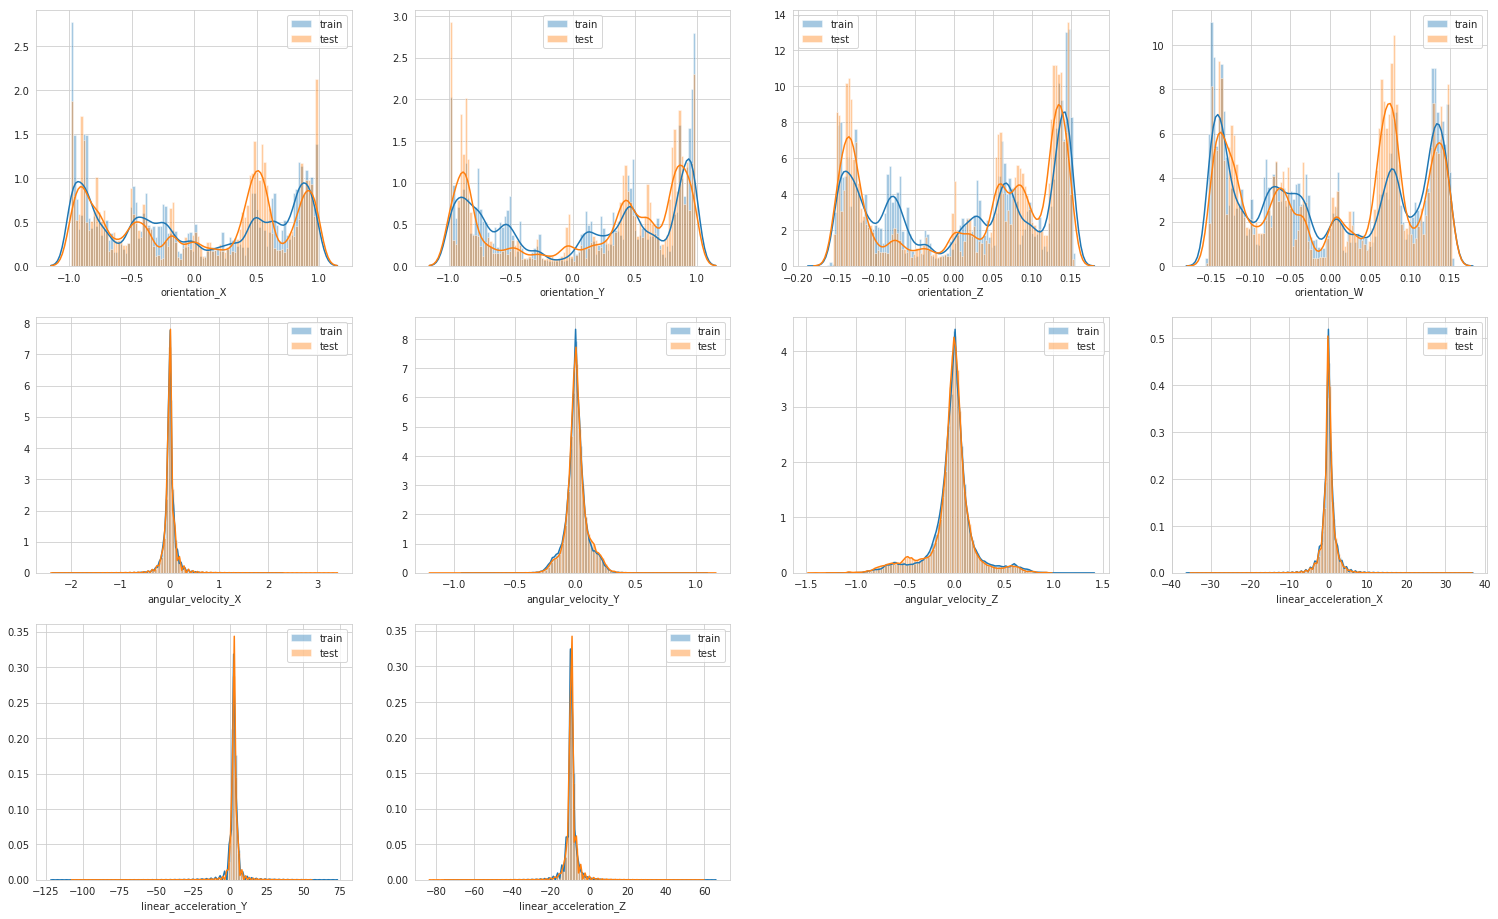

In [154]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(train.columns[3:]):
    ax = plt.subplot(3, 4, i + 1)
    sns.distplot(train[col], bins=100, label='train')
    sns.distplot(test[col], bins=100, label='test')
    ax.legend()   

linear_accelaration are normally distributed/symmetrical distribution but average value is slightly negative for linear_accelaration_Z
X,Y,Z,W orientation data are not symmetrical or bell shaped distributed.
X,Y orientation data are distributed un-even between 1 to -1.
Z,W orientation data are distributed un-even between 1.5 to -1.5
Since orientation data is not linearly distributed, taking log of the orientation data may improve the results.



In [155]:
data=train.merge(y,on="series_id",how='inner')
targets=(y['surface'].value_counts()).index

In [156]:
data.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


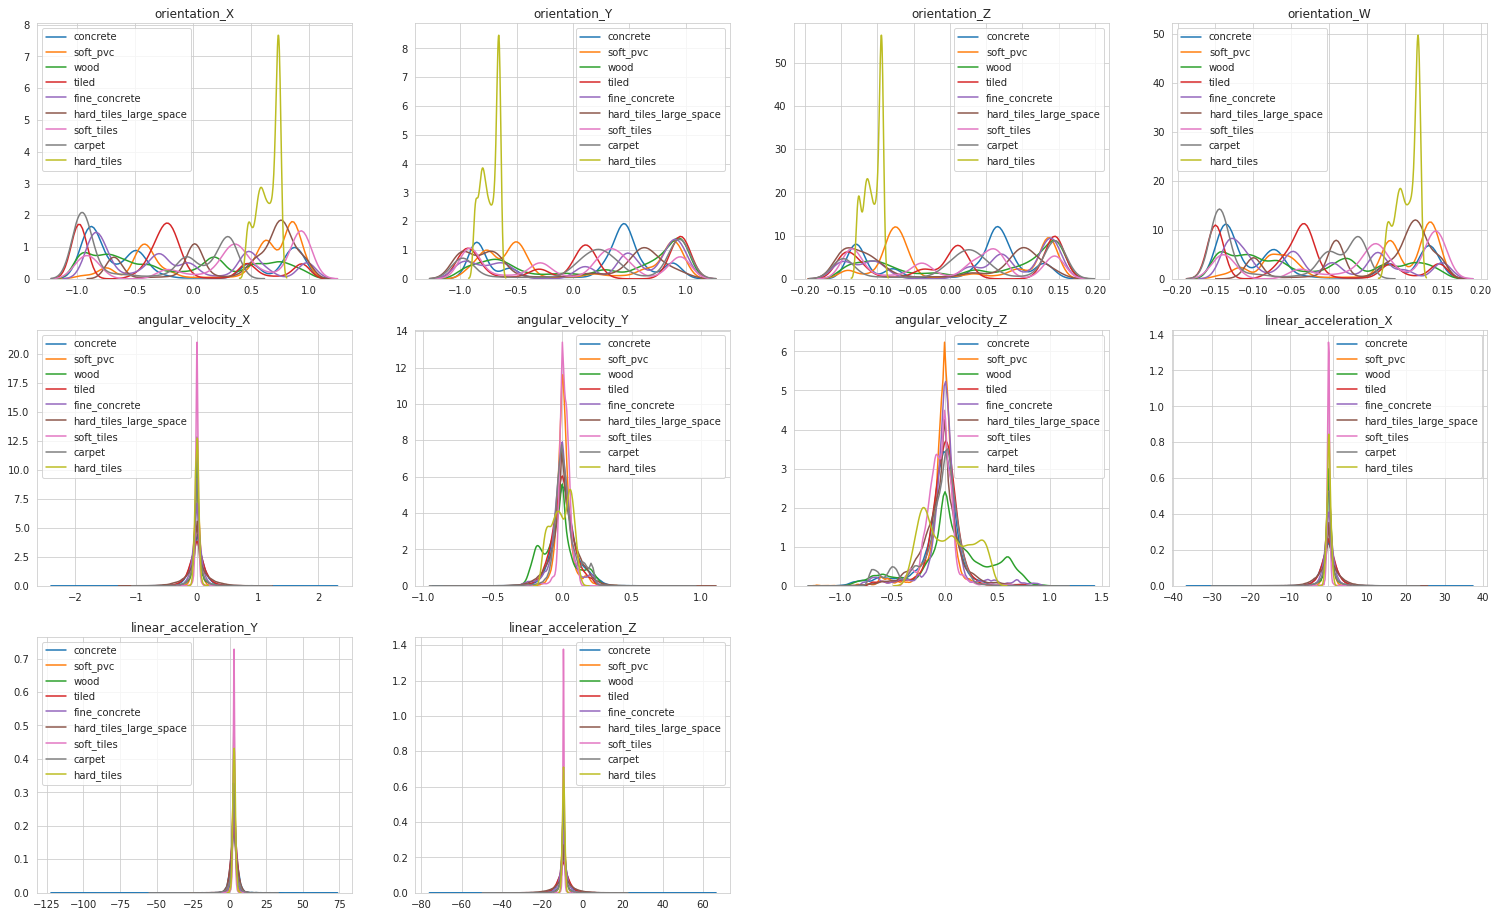

In [157]:
plt.figure(figsize=(26, 16))
for i,col in enumerate(data.columns[3:13]):
    ax = plt.subplot(3,4,i+1)
    ax = plt.title(col)
    for surface in targets:
        surface_feature = data[data['surface'] == surface]
        sns.kdeplot(surface_feature[col], label = surface)

**Feature Engineering **



Euler angles
The Euler angles are three angles introduced by Leonhard Euler to describe the orientation of a rigid body with respect to a fixed coordinate system.

In [158]:
def feature_eng1(df):
    df['norm_q']=df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2 +df['orientation_W'] **2
    df['mor_q']=df['norm_q']**0.5
    df['norm_X']=df['orientation_X']/df['norm_q']
    df['norm_Y']=df['orientation_Y']/df['norm_q']
    df['norm_Z']=df['orientation_Z']/df['norm_q']
    df['norm_W']=df['orientation_W']/df['norm_q']
    
    return df

In [159]:
df=feature_eng1(train)
test=feature_eng1(test)
print(df.shape,test.shape)
df.head()

(487680, 19) (488448, 19)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,norm_q,mor_q,norm_X,norm_Y,norm_Z,norm_W
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.999997,0.999999,-0.758532,-0.634352,-0.104880,-0.105970
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.999995,0.999998,-0.758534,-0.634343,-0.104901,-0.106001
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,1.000006,1.000003,-0.758526,-0.634346,-0.104919,-0.105969
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,1.000009,1.000005,-0.758513,-0.634354,-0.104949,-0.105969
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.999995,0.999997,-0.758524,-0.634353,-0.104951,-0.105961


In [160]:

def feat_eng2(df):
    df['totl_anglr_vel'] = (df['angular_velocity_X']**2 + df['angular_velocity_Y']**2 + df['angular_velocity_Z']**2)** 0.5
    df['totl_linr_acc'] = (df['linear_acceleration_X']**2 + df['linear_acceleration_Y']**2 + df['linear_acceleration_Z']**2)**0.5
    df['totl_orientation'] = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2)**0.5
    df['acc_vs_vel'] = df['totl_linr_acc'] / df['totl_anglr_vel']
    return df


In [161]:
data = feat_eng2(train)
test = feat_eng2(test)
print(data.shape, test.shape)
data.head()

(487680, 23) (488448, 23)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,norm_q,mor_q,norm_X,norm_Y,norm_Z,norm_W,totl_anglr_vel,totl_linr_acc,totl_orientation,acc_vs_vel
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.999997,0.999999,-0.758532,-0.634352,-0.104880,-0.105970,0.109076,10.005392,0.994368,91.728917
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.999995,0.999998,-0.758534,-0.634343,-0.104901,-0.106001,0.074240,9.538638,0.994364,128.483970
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,1.000006,1.000003,-0.758526,-0.634346,-0.104919,-0.105969,0.030428,8.874697,0.994372,291.666195
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,1.000009,1.000005,-0.758513,-0.634354,-0.104949,-0.105969,0.025082,10.164638,0.994374,405.249042
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.999995,0.999997,-0.758524,-0.634353,-0.104951,-0.105961,0.010603,10.556132,0.994368,995.561076


In [162]:
def feat_eng3(df):
    data = pd.DataFrame()
    for col in df.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        data[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        data[col + '_median'] = df.groupby(['series_id'])[col].median()
        data[col + '_max'] = df.groupby(['series_id'])[col].max()
        data[col + '_min'] = df.groupby(['series_id'])[col].min()
        data[col + '_std'] = df.groupby(['series_id'])[col].std()
        data[col + '_range'] = data[col + '_max'] - data[col + '_min']
        data[col + '_maxtoMin'] = data[col + '_max'] / data[col + '_min']
        #in statistics, the median absolute deviation (MAD) is a robust measure of the variablility of a univariate sample of quantitative data.
        data[col + '_mad'] = df.groupby(['series_id'])[col].apply(lambda x: np.median(np.abs(np.diff(x))))
        data[col + '_abs_max'] = df.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        data[col + '_abs_min'] = df.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        data[col + '_abs_avg'] = (data[col + '_abs_min'] + data[col + '_abs_max'])/2
    return data

In [163]:
%%time
data = feat_eng3(train)
test = feat_eng3(test)
print(data.shape, test.shape)
data.head()

(3810, 220) (3816, 220)
CPU times: user 1min 27s, sys: 204 ms, total: 1min 27s
Wall time: 1min 27s


In [164]:
data.fillna(0, inplace = True)
data.replace(-np.inf, 0, inplace = True)
data.replace(np.inf, 0, inplace = True)
test.fillna(0, inplace = True)
test.replace(-np.inf, 0, inplace = True)
test.replace(np.inf, 0, inplace = True)

In [165]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_y = le.fit_transform(y['surface'])


In [166]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_y= le.fit_transform(y['surface'])


**Model Builiding **

In [167]:
folds = StratifiedKFold(n_splits=12, shuffle=True, random_state=60)
predicted = np.zeros((test.shape[0],9))
measured= np.zeros((data.shape[0]))
score = 0

In [168]:
for times, (trn_idx, val_idx) in enumerate(folds.split(data.values,data_y)):
    model = RandomForestClassifier(n_estimators=500, n_jobs = -1)
    #model = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, n_jobs=-1)
    model.fit(data.iloc[trn_idx],data_y[trn_idx])
    measured[val_idx] = model.predict(data.iloc[val_idx])
    predicted += model.predict_proba(test)/folds.n_splits
    score += model.score(data.iloc[val_idx],data_y[val_idx])
    print("Fold: {} score: {}".format(times,model.score(data.iloc[val_idx],data_y[val_idx])))
    
    gc.collect()

Fold: 0 score: 0.903125
Fold: 1 score: 0.846875
Fold: 2 score: 0.878125
Fold: 3 score: 0.8808777429467085
Fold: 4 score: 0.877742946708464
Fold: 5 score: 0.8840125391849529
Fold: 6 score: 0.8683385579937304
Fold: 7 score: 0.8962264150943396
Fold: 8 score: 0.8832807570977917
Fold: 9 score: 0.9076433121019108
Fold: 10 score: 0.8881789137380192
Fold: 11 score: 0.9038461538461539


Understanding about important features will help us fine tuning feature enginnering as well accuracy improvement.



In [169]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

In [170]:
feature_imp = pd.DataFrame(importances, index = data.columns, columns = ['importance'])
feature_imp.sort_values('importance', ascending = False)
feature_imp.head()

,importance
orientation_X_mean,0.011234
orientation_X_median,0.011794
orientation_X_max,0.010875
orientation_X_min,0.010295
orientation_X_std,0.002105


In [171]:
less_important_features = feature_imp.loc[feature_imp['importance'] < 0.0025]
print('There are {0} features their importance value is less then 0.0025'.format(less_important_features.shape[0]))

There are 70 features their importance value is less then 0.0025


In [172]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['surface'] = le.inverse_transform(predicted.argmax(axis=1))
submission.to_csv('rs_surface_submission6.csv', index=False)
submission.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles
5,5,concrete
6,6,soft_pvc
7,7,concrete
8,8,wood
9,9,wood
